# Example isotope simulation
This script illustrates a script that runs a isotope simulation.

## Loading of the package LWFBrook90 and other dependencies:

In [1]:
using LWFBrook90
using OrdinaryDiffEq: solve, Tsit5, init

## Define input data and reading it in:

In [2]:
input_prefix = "isoBEAdense2010-18-reset-FALSE";
input_path = "examples/isoBEAdense2010-18-reset-FALSE-input/";
simulate_isotopes = true
(input_meteoveg,
    input_meteoiso,
    input_meteoveg_reference_date,
    input_param,
    input_storm_durations,
    input_initial_conditions,
    input_soil_horizons,
    simOption_FLAG_MualVanGen) =
    read_inputData(input_path, input_prefix;
        simulate_isotopes = simulate_isotopes);

┌ Warning: Isotopic signature of precipitation data covers the period from
│ 2010-01-01T00:00:00 to 2019-12-31T00:00:00
│ it will be cropped to the period determined by the other meteorologic inputs going from
│ 2010-01-01T00:00:00 to 2011-12-31T00:00:00.
└ @ LWFBrook90 ~/switchdrive/Documents/Job/Anstellung_2019_WSL/Doktorat/Projects/Soil-water-model/Brook/LWFBrook90.jl/src/func_read_inputData.jl:266
┌ Warning: thread = 1 warning: error parsing Float64 around row = 2, col = 6: "NA,", error=INVALID: SENTINEL | DELIMITED | INVALID_DELIMITER 
└ @ CSV ~/.julia/packages/CSV/cHirL/src/file.jl:581
┌ Warning: thread = 1 warning: error parsing Float64 around row = 2, col = 7: "NA,", error=INVALID: SENTINEL | DELIMITED | INVALID_DELIMITER 
└ @ CSV ~/.julia/packages/CSV/cHirL/src/file.jl:581
┌ Warning: thread = 1 warning: error parsing Float64 around row = 3, col = 6: "NA
│ ", error=INVALID: SENTINEL | NEWLINE | INVALID_DELIMITER 
└ @ CSV ~/.julia/packages/CSV/cHirL/src/file.jl:581
┌ Warning: th

## Define grid for spatial discretization as well as initial conditions and root densities
a) either read the discretization from a file `soil_discretization.csv`

In [3]:
unused_in_example = discretize_soil(input_path, input_prefix);
first(unused_in_example, 5)

5×6 DataFrame
 Row │ Upper_m  Lower_m  Rootden_   uAux_PSIM_init_kPa  u_delta18O_init_permil  u ⋯
     │ Float64  Float64  Float64    Float64             Float64              F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    0.0     -0.04  0.0286768                -6.3                -13.0    ⋯
   2 │   -0.04    -0.08  0.0253874                -6.3                -13.0
   3 │   -0.08    -0.12  0.0224752                -6.3                -13.0
   4 │   -0.12    -0.16  0.0198972                -6.3                -13.0
   5 │   -0.16    -0.2   0.0176148                -6.3                -10.0    ⋯
                                                                1 column omitted

b) or define them manually

In [4]:
ψ_init = unused_in_example.uAux_PSIM_init_kPa[1]
Δz_m = [0.04, 0.04, 0.12, 0.25, 0.3, 0.35, 0.1]; # grid spacing (heterogenous), meter (N=7)

f1 = (Δz_m) -> LWFBrook90.Rootden_beta_(0.97, Δz_m = Δz_m)  # function for root density as f(Δz)
f2 = (Δz_m) -> fill(-6.3, length(Δz_m))                     # function for initial conditions as f(Δz)
input_soil_discretization = discretize_soil(;
    Δz_m = Δz_m,
    Rootden_ = f1,
    uAux_PSIM_init_kPa = f2,
    u_delta18O_init_permil = ifelse.(cumsum(Δz_m) .<= 0.2, -13., -10.),
    u_delta2H_init_permil  = ifelse.(cumsum(Δz_m) .<= 0.2, -95., -70.));
first(input_soil_discretization, 5)

5×6 DataFrame
 Row │ Upper_m  Lower_m  Rootden_    uAux_PSIM_init_kPa  u_delta18O_init_permil   ⋯
     │ Float64  Float64  Float64     Float64             Float64               ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   -0.0     -0.04  0.0286768                 -6.3                -13.0   ⋯
   2 │   -0.04    -0.08  0.0253874                 -6.3                -13.0
   3 │   -0.08    -0.2   0.0199958                 -6.3                -13.0
   4 │   -0.2     -0.45  0.0115942                 -6.3                -10.0
   5 │   -0.45    -0.75  0.00507024                -6.3                -10.0   ⋯
                                                                1 column omitted

## Define solver options:

In [5]:
Reset = false;                          # currently only Reset = 0 implemented
compute_intermediate_quantities = true; # Flag whether ODE containes additional quantities than only states

## Override input file settings.
Here there would be the possibility to check and override dataframes input_[...] manually
E.g modifying the soil hydraulic model:
`input_param[1,"NOOUTF"] = true # 'true' if outflow from roots prevented, 'false' if allowed`

## Define parameters for differential equation

In [6]:
(ψM_initial,δ18O_initial,δ2H_initial), p = define_LWFB90_p(
    input_meteoveg,
    input_meteoiso,
    input_meteoveg_reference_date,
    input_param,
    input_storm_durations,
    input_soil_horizons,
    input_soil_discretization,
    simOption_FLAG_MualVanGen;
    Reset = Reset,
    compute_intermediate_quantities = compute_intermediate_quantities,
    simulate_isotopes = simulate_isotopes
    );

# using Plots
# hline([0; cumsum(p[1][1].p_THICK)], yflip = true, xticks = false,
#     title = "N_layer = "*string(p[1][1].NLAYER))

(([-6.3, -6.3, -6.3, -6.3, -6.3, -6.3, -6.3], [-13.0, -13.0, -13.0, -10.0, -10.0, -10.0, -10.0], [-95.0, -95.0, -95.0, -70.0, -70.0, -70.0, -70.0]), ((KPT_SOILPAR_Mvg1d{Vector{Float64}}([40.0, 40.0, 120.00000000000001, 250.0, 300.0, 350.0000000000001, 99.99999999999987], [0.01, 0.175, 0.175, 0.175, 0.01, 0.01, 0.95], [0.7149, 0.66873, 0.6561, 0.60159, 0.52331, 0.56472, 0.46743], [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [24864.67839, 12881.48641, 10516.6166, 3438.06275, 450.35802, 1488.20958, 67.97846], [1147.88919, 1274.88602, 1215.92721, 795.20401, 352.36825, 570.68168, 164.564], [1.05123, 1.05105, 1.05106, 1.05099, 1.05097, 1.05111, 1.05103], [4.67037, 4.47828, 4.50162, 4.34489, 4.29122, 5.14818, 0.01], [0.069, 0.069, 0.069, 0.069, 0.069, 0.069, 0.069], 7, [-0.03207863474423437, -0.020950435128931952, -0.019792563791323055, -0.01651682823593936, -0.008891429678345686, -0.01353584735221954, -0.0015224940289245183], [0.6660783003355155, 0.6306100357834048, 0.6209172162402905, 0.57986984113

## Define initial states of differential equation

In [7]:
# state vector: GWAT,INTS,INTR,SNOW,CC,SNOWLQ,SWATI
# Create u0 for DiffEq.jl
u0, p = define_LWFB90_u0(p, input_initial_conditions,
    ψM_initial, δ18O_initial, δ2H_initial,
    compute_intermediate_quantities;
    simulate_isotopes = simulate_isotopes)

66×1 Matrix{Float64}:
   1.0
   0.0
   0.0
   0.0
   0.0
   0.0
  20.968598937818875
  16.328913996061186
  48.195993898741506
  94.15362685455683
   ⋮
   0.0
   0.0
   0.0
   0.0
   0.0
 455.31063663253445
 456.31063663253445
   0.0
   0.0

## Define ODE problem which consists of
- definition of right-hand-side (RHS) function f
- definition of callback function cb
- u0:     initial condition of states
- tspan:  definition of simulation time span
- p:      parameters

Define simulation time span:

In [8]:
# tspan = (0.,  5.) # simulate 5 days
# tspan = (0.,  100.) # simulate 100 days # NOTE: KAU bugs in "branch 005-" when at least 3*365
tspan = (minimum(input_meteoveg[:,"days"]),
        maximum(input_meteoveg[:,"days"])) # simulate all available days
# tspan = (LWFBrook90.DateTime2RelativeDaysFloat(DateTime(1980,1,1), reference_date),
#          LWFBrook90.DateTime2RelativeDaysFloat(DateTime(1985,1,1), reference_date)) # simulates selected period
# tspan = (0., 700.)

(0.0, 729.0)

Define and solve ODE with package OrdinaryDiffEq:

In [9]:
ode_LWFBrook90, unstable_check_function = define_LWFB90_ODE(u0, tspan, p);

sol_LWFBrook90 = solve(ode_LWFBrook90, Tsit5(); progress = true,
    unstable_check = unstable_check_function, # = (dt,u,p,t) -> false, #any(isnan,u),
    saveat = tspan[1]:tspan[2],
    adaptive = true, dtmin = 1e-3, dt=1e-3,  # if adaptive dt is just the starting value of the time steps
    force_dtmin = true, ## without this callbacks generate an abort "dt <= dtmin",
                        # e.g. see: https://github.com/SciML/DifferentialEquations.jl/issues/648
    maxiters = (tspan[2]-tspan[1])/1e-3 # when using force_dtmin also use maxiters
                    # TODO(bernhard): regarding maxiters it seems to be the callback for δ of SNOW, INTR, INTS that causes the dtmin to be so small to reach large maxiters
    );
# When adding transport of isotopes adaptive time stepping has difficulties reducing dt below dtmin.
# We solve it either by using a constant time step
# or by setting force_dtmin to true, which has the drawback that tolerances are ignored.
# Variant1: less sophisticated but robust:
# adaptive = false, dt=1e-3 #dt=5/60/24 # fixed 5 minutes time steps
# Variant2: more sophisticated but giving errors:

## Plotting

In [10]:
## 0) defined in module_ISO.jl
# using Plots, Measures
# include("module_ISOplots.jl")
# pl_final_δ18O, pl_final_δ2H =
# plot_LWFBrook90_isotopes(sol_LWFBrook90; clims_d18O = (-16, -6), clims_d2H  = (-125, -40));
# plot(pl_final_δ18O, pl_final_δ2H,
#     layout = (2,1), size=(1000,1400), leftmargin = 15mm);
# savefig(input_prefix*".png")
mkpath("out")

using DataFrames
using CSV: File
using Plots, Measures
# fname = joinpath(
#     "out",
#     input_prefix*"_NLAYER+" * string(sol_LWFBrook90.prob.p[1][1].NLAYER)*
#     "-git+"*chomp(read(`git rev-parse --short HEAD`, String)))*
#     ifelse(length(read(`git status --porcelain`, String))==0, "+gitclean","+gitdirty")*
#     "-iso+"*string(simulate_isotopes)

Resulting plot of some aboveground quantities:

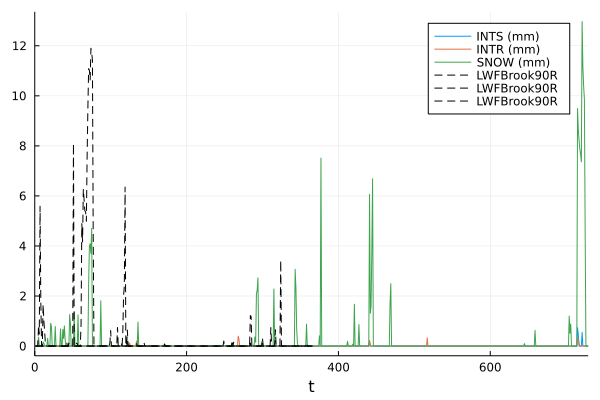

In [11]:
ref_aboveground =
    DataFrame(File(
    # "test/test-assets-external/BEA-2016/BEA-IntegrationTests-LWFBrook90/output_LWFBrook90R/BEA2016-reset-FALSE_NLAYER14_LWFBrook90R-0.4.5daily_output.csv"))[:,
    "out/BEA2016-reset-FALSE_NLAYER14_LWFBrook90R-0.4.5daily_output.csv"))[:,
        [:yr, :mo, :da, :doy, :intr, :ints, :snow, :gwat]]
pl_ab_3 = plot(sol_LWFBrook90; vars = [2, 3, 4],
    label=["INTS (mm)" "INTR (mm)" "SNOW (mm)"])
plot!(pl_ab_3,
        [ref_aboveground.intr,
        ref_aboveground.ints,
        ref_aboveground.snow], label = "LWFBrook90R", line = :dash, color = :black)
# savefig(fname*"_plot-INTS_INTR_SNOW.png")

Resulting plot of other aboveground quantities:

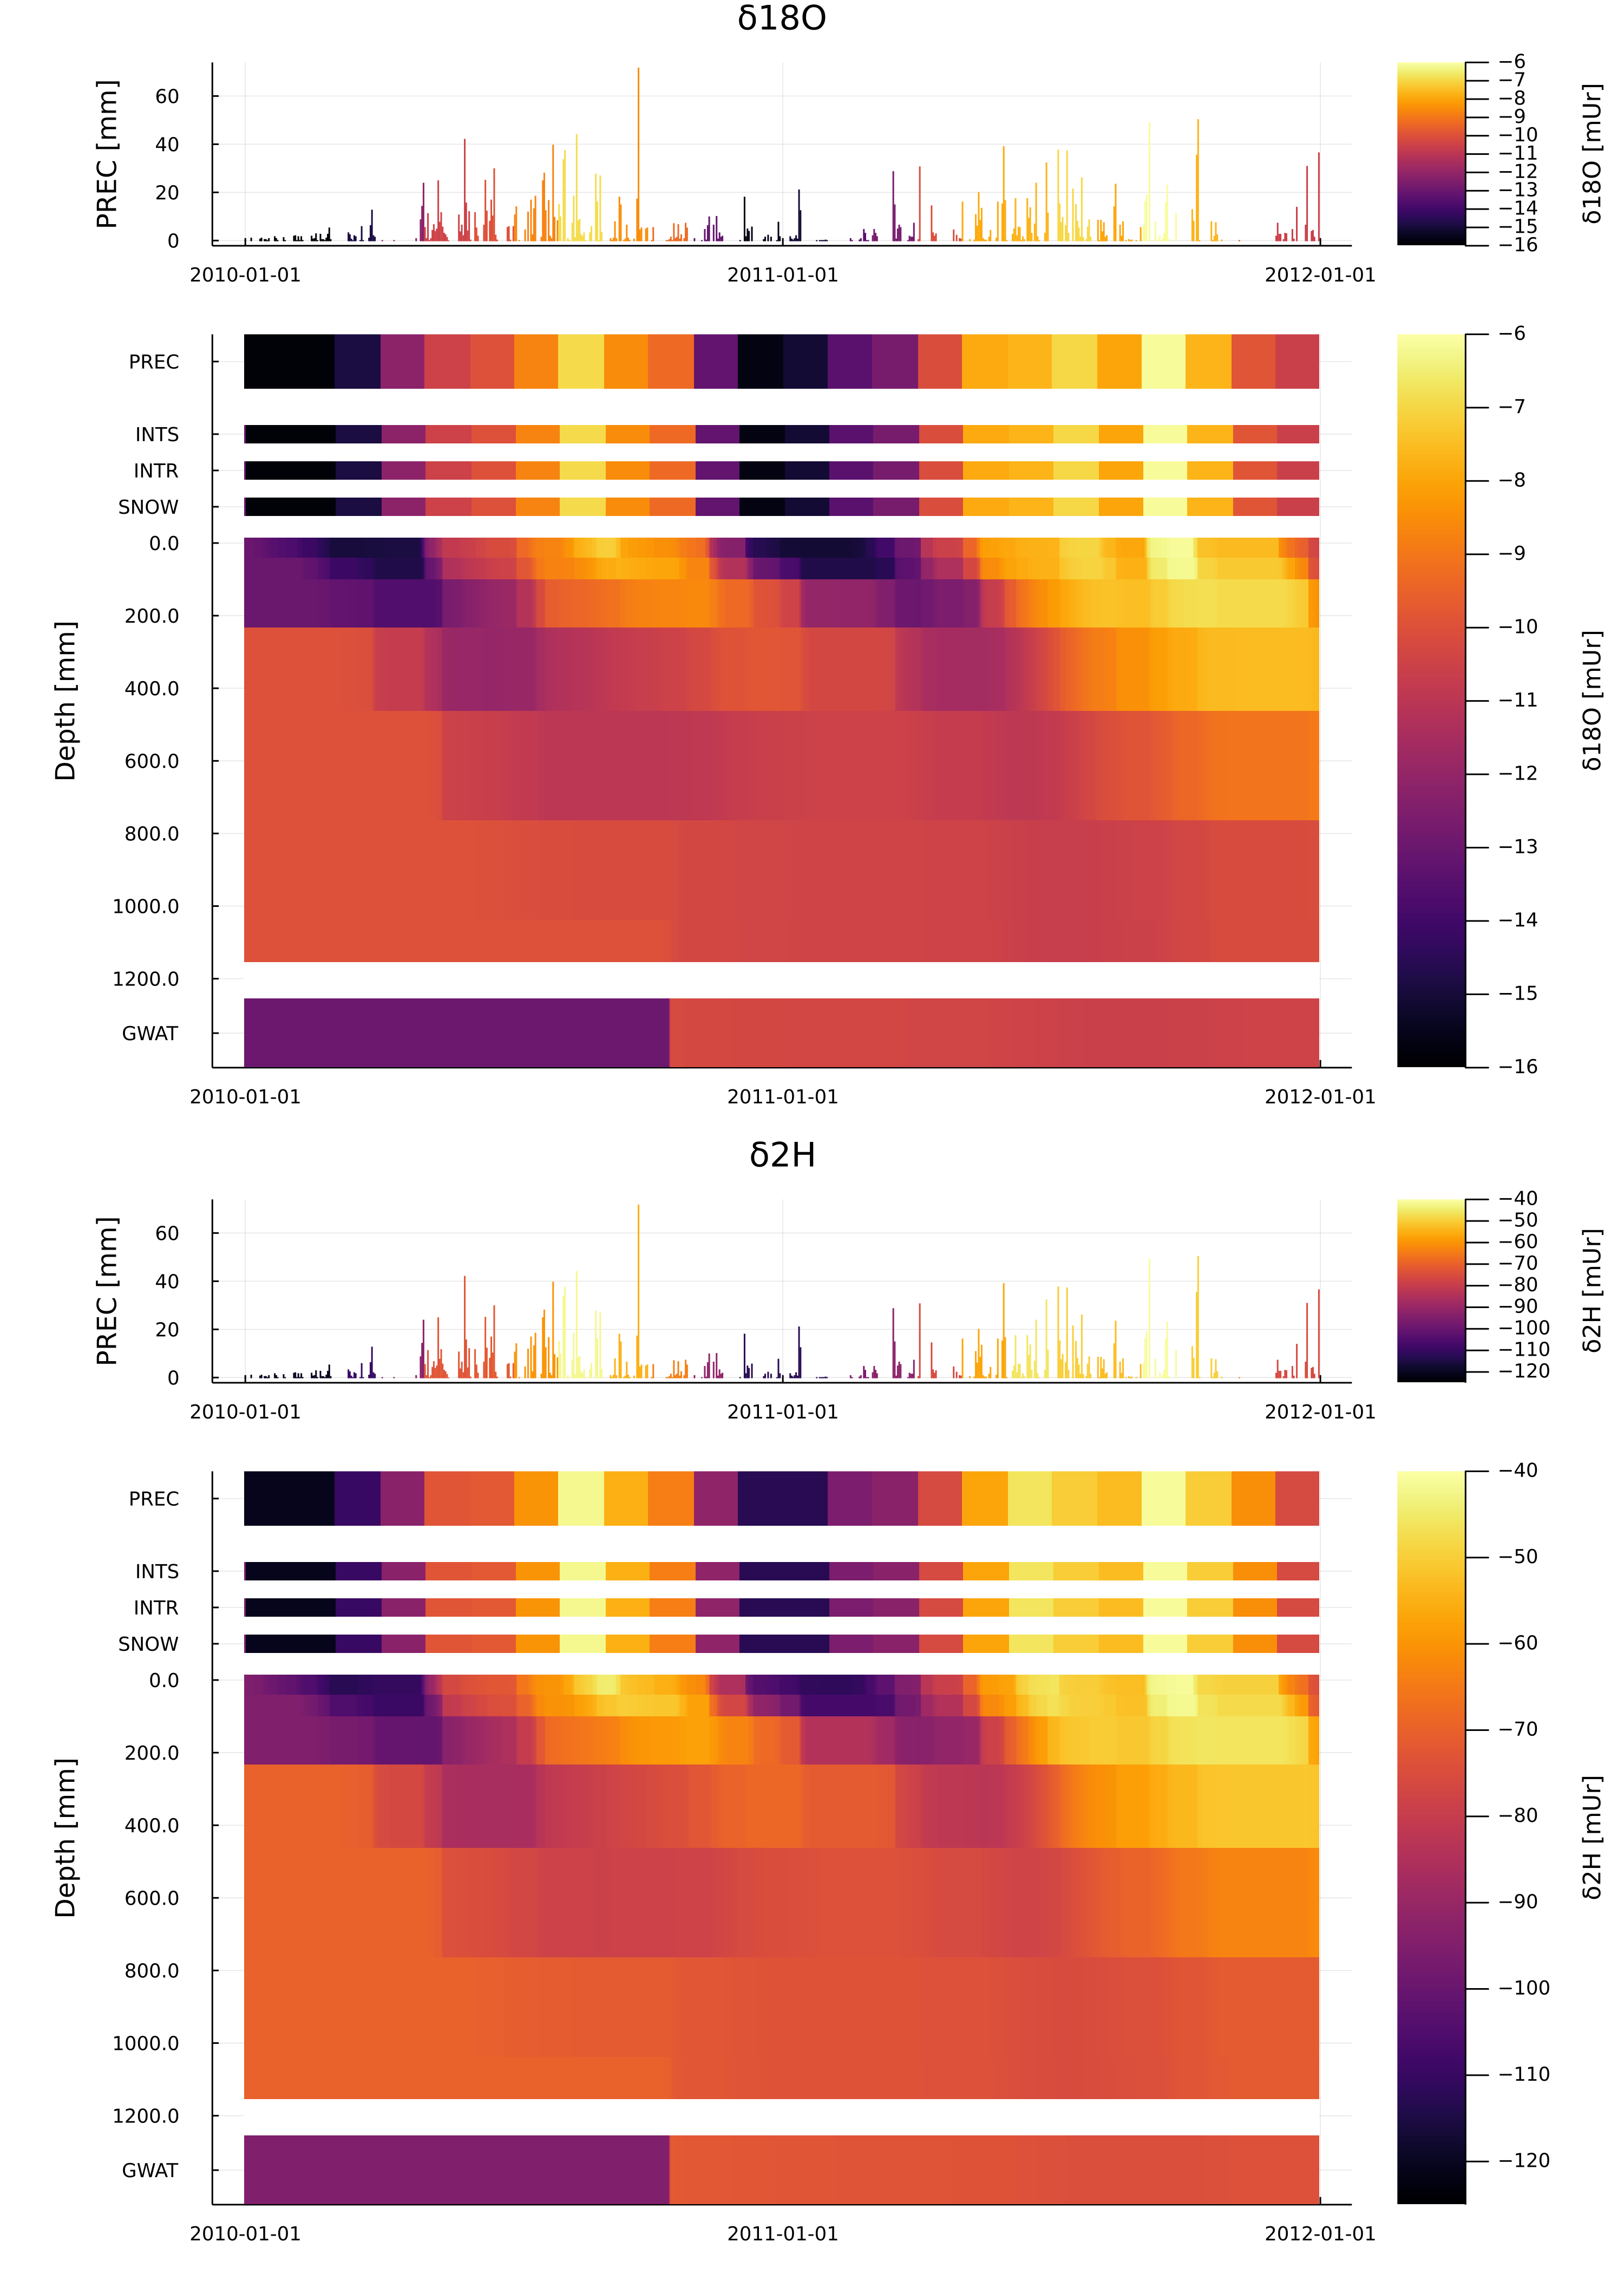

In [12]:
pl_ab_4 = plot(sol_LWFBrook90; vars = [2, 3],
    label=["INTS (mm)" "INTR (mm)"])
plot!(pl_ab_4,
        [ref_aboveground.intr,
        ref_aboveground.ints], label = "LWFBrook90R", line = :dash, color = :black)
# savefig(fname*"_plot-INTS_INTR.png")

optim_ticks = (x1, x2) -> Plots.optimize_ticks(x1, x2; k_min = 4)
# pl1 = LWFBrook90.ISO.plotisotopes(sol_LWFBrook90);
pl2 = LWFBrook90.ISO.plotisotopes(
    sol_LWFBrook90, optim_ticks;
    layout = grid(4, 1, heights=[0.1 ,0.4, 0.1, 0.4]),
    size=(1000,1400), dpi = 300, leftmargin = 15mm);
plot!(pl2, link = :x)
# savefig(pl2, fname*"_plotRecipe.png")

Belowground quantities (θ,ψ,δ of soil water)

In [13]:
PREC_color = :black
depth_to_read_out_mm = [150 500 800 1500]
if simulate_isotopes
    δ_resultsSoil = LWFBrook90.get_δsoil(depth_to_read_out_mm, sol_LWFBrook90)
    δ_results = get_δ(sol_LWFBrook90)
end

pl_θ = plot(LWFBrook90.RelativeDaysFloat2DateTime.(sol_LWFBrook90.t, input_meteoveg_reference_date),
    LWFBrook90.get_θ(depth_to_read_out_mm, sol_LWFBrook90),
    labels = string.(depth_to_read_out_mm) .* "mm",
    xlabel = "Date",
    ylabel = "θ\n[-]",
    legend = :outerright);
pl_ψ = plot(LWFBrook90.RelativeDaysFloat2DateTime.(sol_LWFBrook90.t, input_meteoveg_reference_date),
    # -LWFBrook90.get_ψ(depth_to_read_out_mm, sol_LWFBrook90) .+ 1, yaxis = :log, yflip = true,
    LWFBrook90.get_ψ(depth_to_read_out_mm, sol_LWFBrook90),
    labels = string.(depth_to_read_out_mm) .* "mm",
    xlabel = "Date",
    ylabel = "ψ\n[kPa]",
    legend = :outerright);

if simulate_isotopes
    pl_δ18O = plot(LWFBrook90.RelativeDaysFloat2DateTime.(sol_LWFBrook90.t, input_meteoveg_reference_date),
        δ_resultsSoil[1],
        labels = string.(depth_to_read_out_mm) .* "mm",
        xlabel = "Date",
        ylabel = "δ¹⁸O soil\n[permil]",
        legend = :outerright);
    pl_δ2H = plot(LWFBrook90.RelativeDaysFloat2DateTime.(sol_LWFBrook90.t, input_meteoveg_reference_date),
        δ_resultsSoil[2],
        labels = string.(depth_to_read_out_mm) .* "mm",
        xlabel = "Date",
        ylabel = "δ²H soil\n[permil]",
        legend = :outerright);
    # add precipitation to soil δ
    plot!(pl_δ2H,
        LWFBrook90.RelativeDaysFloat2DateTime.(sol_LWFBrook90.t, input_meteoveg_reference_date),
        δ_results.PREC.d2H', labels = "PREC", color = PREC_color, linestyle = :dot);
    plot!(pl_δ18O,
        LWFBrook90.RelativeDaysFloat2DateTime.(sol_LWFBrook90.t, input_meteoveg_reference_date),
        δ_results.PREC.d18O', labels = "PREC", color = PREC_color, linestyle = :dot);
else
    pl_δ18O = plot();
    pl_δ2H = plot();
end

pl_PREC = plot(
    LWFBrook90.RelativeDaysFloat2DateTime.(sol_LWFBrook90.t, input_meteoveg_reference_date),
    sol_LWFBrook90.prob.p[2][8].(sol_LWFBrook90.t),
    t = :bar, color=PREC_color,
    legend = :outerright, labels = "PREC    ", # whitespace for hardcoded alignment of legend
    ylabel = "PREC\n[mm]");
plot(plot(pl_PREC, xlab = "", xticks = :none, topmargin = 5mm, bottommargin = 0mm),
    plot(pl_θ;     xlab = "", xticks = :none, topmargin = 0mm, bottommargin = 0mm),
    plot(pl_ψ;     xlab = "", xticks = :none, topmargin = 0mm, bottommargin = 0mm),
    plot(pl_δ18O;  xlab = "", xticks = :none, topmargin = 0mm, bottommargin = 0mm),
    plot(pl_δ2H;   xtick_direction=:out     , topmargin = 0mm, bottommargin = 5mm),
    link = :x,
    layout = grid(5, 1, heights=[0.1, 0.25 ,0.25, 0.2, 0.2]),
    size=(600,500), dpi = 300, margin = 5mm)

#
# aux_indices = sol_LWFBrook90.prob.p[1][4].row_idx_accum
# aux_names = sol_LWFBrook90.prob.p[1][4].names_accum
# plot(LWFBrook90.RelativeDaysFloat2DateTime.(sol_LWFBrook90.t, input_meteoveg_reference_date),
#             [sol_LWFBrook90[aux_indices[30],:] sol_LWFBrook90[aux_indices[31],:]],
#             legend = :outerright, labels = aux_names[:, 30:31],
#             ylabel = "Water balance error [mm]")
# ## savefig(fname*"_plot-water-balance-error.png")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*